import the saved outputs from Stage 1

build a rectangular dataset:

one row per child

parent homeownership

child education

answer:

“Is there an association?”

## This notebook analyzes whether parental homeownership (1968) is associated
with children's educational attainment.


# Libraries

In [1]:
import pandas as pd
import numpy as np

# Options

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to the directory containing your CSV
#%cd /content/drive/MyDrive/DATA/Real_Estate_Data
%cd /content/drive/MyDrive/DATA/PSID_data

Mounted at /content/drive
/content/drive/MyDrive/DATA/PSID_data


In [4]:
import pandas as pd

df = pd.read_csv(
    "/content/drive/MyDrive/DATA/PSID_data/parent_child_all.csv"
)

df.shape


(59626, 11)

In [5]:
df.head(5)

,parent_id,child_id,G1TYPE,G2TYPE,parent_person_id,parent_ER32000,parent_ER32006,parent_V103,child_person_id,child_ER32000,child_ER32006
0,2002,2171,M,F,2002.0,2.0,1.0,5.0,2171.0,1.0,0.0
1,2002,2172,M,I,2002.0,2.0,1.0,5.0,2172.0,1.0,0.0
2,2002,2902,M,I,2002.0,2.0,1.0,5.0,NaN,NaN,NaN
3,2002,2903,M,I,2002.0,2.0,1.0,5.0,NaN,NaN,NaN
4,2002,2904,M,I,2002.0,2.0,1.0,5.0,NaN,NaN,NaN


In [6]:
for col in df.columns:
    print(col)

parent_id
child_id
G1TYPE
G2TYPE
parent_person_id
parent_ER32000
parent_ER32006
parent_V103
child_person_id
child_ER32000
child_ER32006


# Missing education data.  Will import and merge


In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "/content/drive/MyDrive/DATA/PSID_data/parent_child_all.csv"
)

df.shape


(59626, 11)

In [8]:
people = pd.read_csv(
    "/content/drive/MyDrive/DATA/PSID_data/psid_person_lookup.csv"
)

people.columns


Index(['person_id', 'ER32000', 'ER32006', 'ER30004', 'V103', 'ER30584',
       'ER34952', 'ER35152'],
      dtype='object')

In [9]:
# The Merge

df = df.merge(
    people[["person_id", "ER35152", "ER34952", "ER30584"]],
    left_on="child_person_id",
    right_on="person_id",
    how="left"
)

# Create a single education variable (latest available)
df["child_edu"] = (
    df["ER35152"]
      .fillna(df["ER34952"])
      .fillna(df["ER30584"])
)


## Add Age Variables

In [10]:
# Step 2 — Sanity check education

# ~80% of children have a valid education outcome

# ~20% are missing — which is:

# expected in PSID

# consistent with age / attrition

# much better than earlier diagnostics you saw

df["child_edu"].describe()
df["child_edu"].isna().mean()


np.float64(0.19873880521919968)

In [11]:
# Step 3 — Compare education by parent homeownership

# 1 = 2-~20k of homeowners
# 0 = ~18k of renters
# Why so many NANs?  Living w Relatives, missed interview, institionalized, other

import numpy as np

# 1 = Own, 5 = Rent (everything else -> missing)
df["parent_owner"] = np.where(
    df["parent_V103"] == 1, 1,
    np.where(df["parent_V103"] == 5, 0, np.nan)
)

df["parent_owner"].value_counts(dropna=False)



,count
parent_owner,
NaN,20593
1.0,20571
0.0,18462


In [12]:
# Step 4 — Compare education by homeownership (excluding NaNs)

df.loc[df["parent_owner"].notna()] \
  .groupby("parent_owner")["child_edu"] \
  .agg(["mean", "count"])


,mean,count
parent_owner,,
0.0,4.201272,15561
1.0,5.095300,17765


In [13]:
# Option 1: Add a single control (child sex)
# 1 = male
# 2 = female

df.groupby(["parent_owner", "child_ER32000"])["child_edu"] \
  .mean() \
  .unstack()


child_ER32000,1.0,2.0
parent_owner,,
0.0,3.673261,4.750820
1.0,4.649927,5.546578


In [14]:
# # let us add Race as a variable
# # 1= white
# # 2 = black
# # 3 = Other
# # 0,5,6 = note race codes

# df.groupby(["parent_owner", "child_ER32006"])["child_edu"] \
#   .mean() \
#   .unstack()


In [15]:
# let us add Race as a variable
# 1= white
# 2 = black
# 3 = Other


df.loc[
    df["child_ER32006"].isin([1, 2, 3]) &
    df["parent_owner"].notna()
].groupby(
    ["parent_owner", "child_ER32006"]
)["child_edu"].agg(["mean", "count"]).unstack()


mean                     count            
child_ER32006       1.0       2.0       3.0   1.0   2.0   3.0
parent_owner                                                 
0.0            3.244366  4.754551  5.182148  4792  8955  1378
1.0            5.179587  5.246247  5.506626  6398  9860   981

In [16]:
# Regression

import statsmodels.formula.api as smf

reg_df = df.loc[
    df["parent_owner"].notna() &
    df["child_ER32000"].notna() &
    df["child_ER32006"].isin([1, 2, 3])
].copy()

model = smf.ols(
    "child_edu ~ parent_owner + C(child_ER32000) + C(child_ER32006)",
    data=reg_df
).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              child_edu   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     68.34
Date:                Mon, 26 Jan 2026   Prob (F-statistic):           1.06e-57
Time:                        20:29:53   Log-Likelihood:            -1.1536e+05
No. Observations:               32364   AIC:                         2.307e+05
Df Residuals:                   32359   BIC:                         2.308e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.2857      0.108     30.382      0.000       3.074       3.498
C(child_ER32000)[T.2.0]     1.0338      0.095     10.878      0.000       0.847       1.220
C(child_ER32006)[T.2.0]     0.7123      0.102      6.974      0.000       0.512       0.912
C(child_ER32006)[T.3.0]     1.1183      0.194      5.758      0.000       0.738       1.499
parent_owner                0.9682      0.096     10.135      0.000       0.781       1.155
==============================================================================
Omnibus:                    33389.943   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3435430.489
Skew:                           4.999   Prob(JB):                         0.00
Kurtosis:                      52.474   Cond. No.                         6.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

10. The Big Interpretive Question You’ve Now Earned

Your result is strong enough to raise a real causal challenge:

Is homeownership itself doing something — stability, school continuity, neighborhood quality, wealth accumulation — or is it mostly standing in for income and class?

This model can’t answer that yet — but it’s now strong enough to justify testing it.

R² = 0.008 → 0.8%

So:

99.2% of the variation in education is explained by things NOT in your model

**That’s like trying to explain a whole person’s life using three levers. The fact that any one of them shows a strong effect is actually notable.**

### Homeownership doesn’t explain much of everyone’s story

But it explains a consistent difference between two groups

When Adjusted R² matters more

Later, when you start adding:

Income

Parent education

Region

Family size

Cohort

Possibly Gen2 traits

Adjusted R² becomes the honesty check:

“Did this model actually get better, or just bigger?”

Your model says:

You didn’t explain much of everyone’s life

But you found a real, stable, non-random difference between children of homeowners and non-homeowners

## Make output pretty

In [17]:
LABELS = {
    "Intercept": "Baseline (Reference Child)",
    "parent_owner": "Parent Homeowner (1968)",

    "C(child_ER32000)[T.2.0]": "Child Sex: Female (vs Male)",

    "C(child_ER32006)[T.2.0]": "Child Race: Black (vs White)",
    "C(child_ER32006)[T.3.0]": "Child Race: Other (vs White)",
}


In [18]:
import pandas as pd
import numpy as np

def pretty_regression_table(model, label_map):
    df = pd.DataFrame({
        "Variable": model.params.index,
        "Coefficient": model.params.values,
        "Std Error": model.bse.values,
        "p-value": model.pvalues.values,
        "CI Lower": model.conf_int()[0].values,
        "CI Upper": model.conf_int()[1].values,
    })

    # Apply human labels
    df["Label"] = df["Variable"].map(label_map).fillna(df["Variable"])

    # Significance stars
    def stars(p):
        if p < 0.001:
            return "***"
        elif p < 0.01:
            return "**"
        elif p < 0.05:
            return "*"
        else:
            return ""

    df["Sig"] = df["p-value"].apply(stars)

    # Formatting
    for col in ["Coefficient", "Std Error", "CI Lower", "CI Upper"]:
        df[col] = df[col].round(3)

    df["p-value"] = df["p-value"].apply(lambda x: f"{x:.3g}")

    # Final layout
    pretty = df[[
        "Label",
        "Coefficient",
        "Std Error",
        "CI Lower",
        "CI Upper",
        "p-value",
        "Sig"
    ]]

    return pretty


In [19]:
pretty_table = pretty_regression_table(model, LABELS)
pretty_table


,Label,Coefficient,Std Error,CI Lower,CI Upper,p-value,Sig
0,Baseline (Reference Child),3.286,0.108,3.074,3.498,6.23e-200,***
1,Child Sex: Female (vs Male),1.034,0.095,0.847,1.220,1.64e-27,***
2,Child Race: Black (vs White),0.712,0.102,0.512,0.912,3.14e-12,***
3,Child Race: Other (vs White),1.118,0.194,0.738,1.499,8.58e-09,***
4,Parent Homeowner (1968),0.968,0.096,0.781,1.155,4.19e-24,***


In [20]:
summary_panel = pd.DataFrame({
    "Metric": ["Observations", "R-squared", "Adj. R-squared", "F-statistic", "Prob(F-stat)"],
    "Value": [
        int(model.nobs),
        round(model.rsquared, 4),
        round(model.rsquared_adj, 4),
        round(model.fvalue, 2),
        f"{model.f_pvalue:.2e}"
    ]
})

summary_panel


,Metric,Value
0,Observations,32364
1,R-squared,0.0084
2,Adj. R-squared,0.0083
3,F-statistic,68.34
4,Prob(F-stat),1.06e-57


## What This Plot Shows (Conceptually)

We’re going to ask your model:

“If I take two otherwise identical children — same sex, same race — but one’s parent owned a home in 1968 and the other didn’t, how much education does the model predict for each?”

Then we’ll plot:

Non-owner

Owner
with confidence intervals.

## Step 1 — Pick a “Reference Child”

We need fixed values for the controls.

Let’s use:

Male (ER32000 = 1)

White (ER32006 = 1)

You can change this later — the gap between owner and non-owner will stay the same.

## Step 2 — Build a Prediction DataFrame

This part is critical because you used categorical variables (C(...)) in the model. So we must build the same structure.

In [21]:
import pandas as pd
import numpy as np

# Two scenarios: non-owner vs owner
pred_df = pd.DataFrame({
    "parent_owner": [0, 1],
    "child_ER32000": [1, 1],  # Reference sex (Male)
    "child_ER32006": [1, 1],  # Reference race (White)
})


## Step 3 — Use the Model to Predict with Confidence Intervals

In [22]:
predictions = model.get_prediction(pred_df).summary_frame(alpha=0.05)

plot_df = pred_df.copy()
plot_df["Predicted Education"] = predictions["mean"]
plot_df["CI Lower"] = predictions["mean_ci_lower"]
plot_df["CI Upper"] = predictions["mean_ci_upper"]

plot_df["Homeownership"] = plot_df["parent_owner"].map({
    0: "Non-Owner (1968)",
    1: "Owner (1968)"
})

plot_df


,parent_owner,child_ER32000,child_ER32006,Predicted Education,CI Lower,CI Upper,Homeownership
0,0,1,1,3.285672,3.073700,3.497643,Non-Owner (1968)
1,1,1,1,4.253844,4.053629,4.454059,Owner (1968)


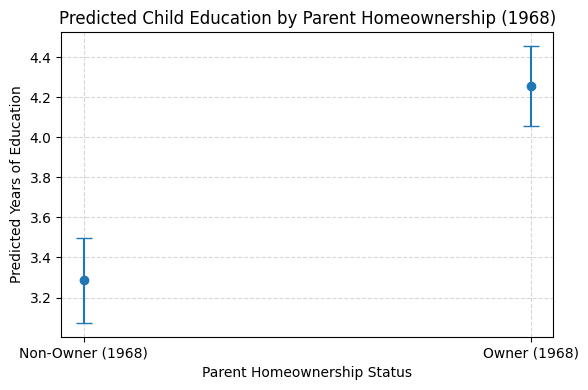

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

x = plot_df["Homeownership"]
y = plot_df["Predicted Education"]
yerr = [
    y - plot_df["CI Lower"],
    plot_df["CI Upper"] - y
]

plt.errorbar(
    x, y,
    yerr=yerr,
    fmt="o",
    capsize=6
)

plt.title("Predicted Child Education by Parent Homeownership (1968)")
plt.ylabel("Predicted Years of Education")
plt.xlabel("Parent Homeownership Status")

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


##Concept

We’ll ask the model four questions at once:

Sex plot

Male, Non-owner

Male, Owner

Female, Non-owner

Female, Owner

Race plot

White, Non-owner

White, Owner

Black, Non-owner

Black, Owner

Then we’ll draw two lines:

One line per group

Vertical movement = predicted education

In [24]:
#Step 1 — Helper Function (Reusable)

import pandas as pd
import numpy as np

def build_prediction_df(model, scenarios, group_label):
    df = pd.DataFrame(scenarios)
    preds = model.get_prediction(df).summary_frame(alpha=0.05)

    df_out = df.copy()
    df_out["Predicted"] = preds["mean"]
    df_out["CI Lower"] = preds["mean_ci_lower"]
    df_out["CI Upper"] = preds["mean_ci_upper"]
    df_out["Group"] = group_label

    return df_out


In [25]:
#Step 2 — Male vs Female Overlay

sex_scenarios = [
    # Male
    {"parent_owner": 0, "child_ER32000": 1, "child_ER32006": 1},
    {"parent_owner": 1, "child_ER32000": 1, "child_ER32006": 1},

    # Female
    {"parent_owner": 0, "child_ER32000": 2, "child_ER32006": 1},
    {"parent_owner": 1, "child_ER32000": 2, "child_ER32006": 1},
]

sex_df = build_prediction_df(model, sex_scenarios, "Sex")

sex_df["Label"] = [
    "Male – Non-owner",
    "Male – Owner",
    "Female – Non-owner",
    "Female – Owner",
]

sex_df


,parent_owner,child_ER32000,child_ER32006,Predicted,CI Lower,CI Upper,Group,Label
0,0,1,1,3.285672,3.073700,3.497643,Sex,Male – Non-owner
1,1,1,1,4.253844,4.053629,4.454059,Sex,Male – Owner
2,0,2,1,4.319433,4.106126,4.532739,Sex,Female – Non-owner
3,1,2,1,5.287605,5.086908,5.488301,Sex,Female – Owner


In [26]:
# Step 3 — White vs Black Overlay

race_scenarios = [
    # White
    {"parent_owner": 0, "child_ER32000": 1, "child_ER32006": 1},
    {"parent_owner": 1, "child_ER32000": 1, "child_ER32006": 1},

    # Black
    {"parent_owner": 0, "child_ER32000": 1, "child_ER32006": 2},
    {"parent_owner": 1, "child_ER32000": 1, "child_ER32006": 2},
]

race_df = build_prediction_df(model, race_scenarios, "Race")

race_df["Label"] = [
    "White – Non-owner",
    "White – Owner",
    "Black – Non-owner",
    "Black – Owner",
]

race_df


,parent_owner,child_ER32000,child_ER32006,Predicted,CI Lower,CI Upper,Group,Label
0,0,1,1,3.285672,3.073700,3.497643,Race,White – Non-owner
1,1,1,1,4.253844,4.053629,4.454059,Race,White – Owner
2,0,1,2,3.997946,3.816867,4.179024,Race,Black – Non-owner
3,1,1,2,4.966118,4.789236,5.142999,Race,Black – Owner


In [27]:
# Step 4 — Plot Function (Two-Line Overlay)

import matplotlib.pyplot as plt

def plot_overlay(df, title):
    plt.figure(figsize=(7, 4))

    for group in df["Label"].str.split(" – ").str[0].unique():
        sub = df[df["Label"].str.startswith(group)]

        x = ["Non-owner", "Owner"]
        y = sub["Predicted"].values

        yerr = [
            y - sub["CI Lower"].values,
            sub["CI Upper"].values - y
        ]

        plt.errorbar(
            x, y,
            yerr=yerr,
            marker="o",
            capsize=5,
            label=group
        )

    plt.title(title)
    plt.ylabel("Predicted Years of Education")
    plt.xlabel("Parent Homeownership Status (1968)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


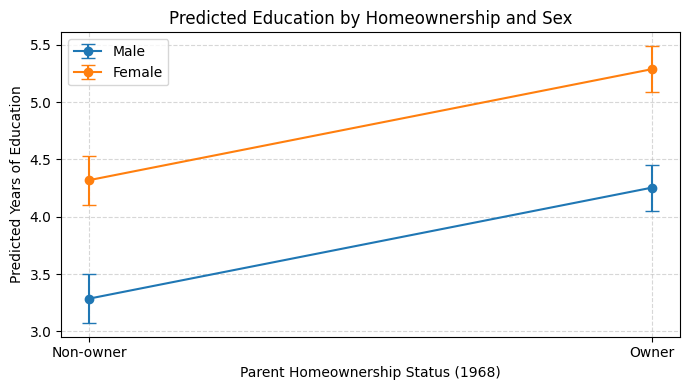

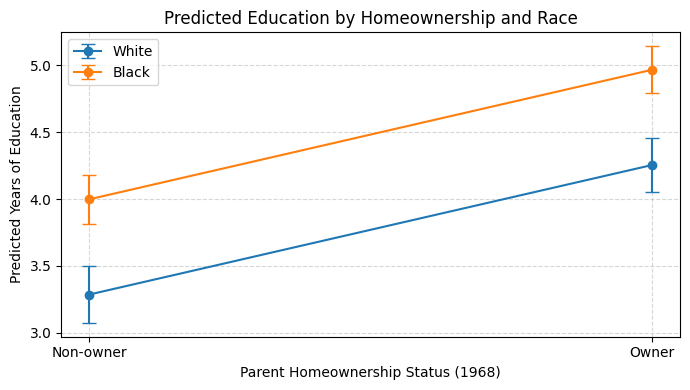

In [28]:
#Step 5 — Make the Two Plots

plot_overlay(sex_df, "Predicted Education by Homeownership and Sex")
plot_overlay(race_df, "Predicted Education by Homeownership and Race")

# How to Read These Like a Researcher
What Parallel Lines Mean

If:

Male and Female lines are parallel
→ Homeownership has a similar effect for both groups

What Diverging Lines Mean

If:

Female line slopes more steeply than Male
→ Homeownership matters more for girls than boys

Same logic for White vs Black.

What You’re Now Testing (Quietly but Powerfully)

You’ve moved from:

“Does homeownership matter?”

to:

“For whom does homeownership matter most?”

That’s exactly where intergenerational mobility research becomes theory-driven instead of purely descriptive.

In [29]:
# Sanity check
# kids with 0  years of education and people not present coded as "99"
# are skewing the results
#  Need to screen them

reg_df["child_edu"].describe()


,child_edu
count,32364.000000
mean,4.805772
std,8.582462
min,0.000000
25%,0.000000
50%,0.000000
75%,12.000000
max,99.000000


In [30]:
psid_model = reg_df.copy()

psid_model["child_edu_clean"] = psid_model["child_edu"].replace({
    0: np.nan,
    99: np.nan
})


In [31]:
# Now re-check the distribution

# notice that the observations dropped
# from 32k to 10k

psid_model["child_edu_clean"].describe()


,child_edu_clean
count,10609.000000
mean,13.596757
std,2.227979
min,4.000000
25%,12.000000
50%,13.000000
75%,16.000000
max,17.000000


In [32]:
## Restart here

In [33]:
# Confirm we have Age

psid_model.columns[psid_model.columns.str.contains("age|birth|year", case=False)]


Index([], dtype='object')

In [34]:
[col for col in psid_model.columns if any(k in col.lower()
 for k in ["age", "birth", "year", "yr", "dob"])]


[]

In [35]:
import pandas as pd
import numpy as np

def find_age_like_cols(df, min_nonnull=200, max_age=105):
    candidates = []
    for c in df.columns:
        s = df[c]
        if not pd.api.types.is_numeric_dtype(s):
            continue
        nonnull = s.notna().sum()
        if nonnull < min_nonnull:
            continue

        # age-ish: mostly integers between 0 and max_age
        s2 = s.dropna()
        in_range = ((s2 >= 0) & (s2 <= max_age)).mean()
        integerish = (np.isclose(s2, np.round(s2))).mean()

        if in_range > 0.90 and integerish > 0.90:
            candidates.append((c, nonnull, float(s2.min()), float(s2.max()), float(s2.median()), in_range))

    out = pd.DataFrame(candidates, columns=["col", "nonnull", "min", "max", "median", "pct_in_0_105"])
    return out.sort_values(["pct_in_0_105", "nonnull"], ascending=False)

age_candidates = find_age_like_cols(psid_model)
age_candidates.head(25)


,col,nonnull,min,max,median,pct_in_0_105
0,parent_ER32000,32364,1.0,2.0,2.0,1.0
1,parent_ER32006,32364,0.0,5.0,1.0,1.0
2,parent_V103,32364,1.0,5.0,1.0,1.0
3,child_ER32000,32364,1.0,2.0,1.0,1.0
4,child_ER32006,32364,1.0,3.0,2.0,1.0
5,ER35152,32364,0.0,99.0,0.0,1.0
6,ER34952,32364,0.0,99.0,0.0,1.0
7,ER30584,32364,0.0,99.0,0.0,1.0
8,child_edu,32364,0.0,99.0,0.0,1.0
9,parent_owner,32364,0.0,1.0,1.0,1.0


In [36]:
# get the name of the variable

import os

os.listdir("/content/drive/MyDrive/DATA/PSID_data")


['PSID Family Tree.pdf',
 'Ego_alter_matrix_rrp.xlsx',
 'Ego_alter_matrix_rel.xlsx',
 'MX21_readme.pdf',
 'MX21intro.pdf',
 'MX21REL.txt',
 'MX21REL_codebook.pdf',
 'fim14675_gid_BO_3_UBL_wide_cds.xlsx',
 'fim14676_gid_BO_3_UBL_wide.sas7bdat',
 'fim14680_gid_BO_4_UBL_wide_cds.sas7bdat',
 'fim14681_gid_BO_4_UBL_wide_cds.sas7bdat',
 'J344674.trp',
 'psid_march_21.xlsx',
 'variable list.gdoc',
 'psid_march_21_two.xlsx',
 'J345266.xlsx',
 'J345266.csv',
 'fim14752_gid_BO_2_BAL_wide.csv',
 'fim14752_gid_BO_3_BAL_wide.csv',
 'J345639.xlsx',
 'PSID_639_labels.csv',
 'J345639.csv',
 'J346064_codebook.pdf',
 'J346064_labels.txt',
 'J346064.csv',
 'J346106_codebook.pdf',
 'J346106_labels.txt',
 'J346106.csv',
 'J346233_v5.csv',
 'J346282.csv',
 'J346241.csv',
 'J346321.xlsx',
 'J346321_labels.txt',
 'J346321_codebook.pdf',
 'J346321.csv',
 'J346323.xlsx',
 'J346323_codebook.pdf',
 'J346323_labels.txt',
 'J346323.csv',
 'J346343_codebook.pdf',
 'J346343.xlsx',
 'J346343_labels.txt',
 'J346343.csv

In [37]:
psid_time = pd.read_csv(
    "/content/drive/MyDrive/DATA/PSID_data/J357352.csv"
)

psid_time.shape


(85536, 213)

In [38]:
psid_time.columns[:20]


Index(['ER30000', 'ER30001', 'ER30002', 'ER32000', 'ER32006', 'ER30003',
       'ER30004', 'ER30020', 'ER30021', 'ER30022', 'ER30023', 'ER30043',
       'ER30044', 'ER30045', 'ER30046', 'ER30067', 'ER30068', 'ER30069',
       'ER30070', 'ER30091'],
      dtype='object')

In [39]:
psid_time_small = psid_time[["ER30001", "ER30002", "ER30046"]].copy()


In [40]:
for c in [col for col in ["ER30046", "ER30004"] if col in psid_time_small.columns]:
    psid_time_small[c] = psid_time_small[c].replace({0: pd.NA, 999: pd.NA})


In [41]:
[c for c in psid_model.columns if "30001" in c or "30002" in c or "person_id" in c.lower() or "interview" in c.lower()]


['parent_person_id', 'child_person_id', 'person_id']

In [42]:
psid_time_small = psid_time[["ER30001", "ER30002", "ER30046", "ER30004"]].copy()

# clean missing codes
for c in ["ER30046", "ER30004"]:
    psid_time_small[c] = psid_time_small[c].replace({0: pd.NA, 999: pd.NA})

# create person_id consistent with your project convention
psid_time_small["person_id"] = psid_time_small["ER30001"] * 1000 + psid_time_small["ER30002"]


In [43]:
psid_model = psid_model.merge(
    psid_time_small[["person_id", "ER30046", "ER30004"]],
    left_on="child_person_id",
    right_on="person_id",
    how="left",
    validate="m:1"
)



In [44]:
psid_model["birth_year"] = pd.NA

mask_70 = psid_model["ER30046"].notna()
psid_model.loc[mask_70, "birth_year"] = 1970 - psid_model.loc[mask_70, "ER30046"]

mask_68 = psid_model["birth_year"].isna() & psid_model["ER30004"].notna()
psid_model.loc[mask_68, "birth_year"] = 1968 - psid_model.loc[mask_68, "ER30004"]


In [45]:
OUTCOME_YEAR = 2005  # change later if needed

psid_model["child_age"] = OUTCOME_YEAR - psid_model["birth_year"]
psid_model["observable"] = psid_model["child_age"] >= 25

psid_model[["child_person_id", "birth_year", "child_age", "observable"]].head(10)


,child_person_id,birth_year,child_age,observable
0,4003.0,1952,53,True
1,4004.0,1954,51,True
2,4005.0,1956,49,True
3,4006.0,1958,47,True
4,4007.0,1961,44,True
5,4008.0,1966,39,True
6,4003.0,1952,53,True
7,4004.0,1954,51,True
8,4005.0,1956,49,True
9,4006.0,1958,47,True


In [46]:
psid_model["birth_year"].describe()
psid_model["child_age"].describe()
psid_model["observable"].value_counts(dropna=False)


,count
observable,
False,20440
True,11924


In [47]:
 # psid_model["observable"] = psid_model["child_age"] >= 25

# Step 10.6 — Define observability (age at outcome threshold)
psid_model["observable"] = psid_model["child_age"] >= 25

In [48]:
# ## Add Age Variables

# psid_time = pd.read_csv(
#     "/content/drive/MyDrive/DATA/PSID_data/J357352.csv"
# )

# psid_time.shape


# Model 2 — Education Outcome (Only Observable Sample)

This answers:

“Among those who could have finished school, does parent homeownership matter?”

Step 11.2 — Outcome Model

In [49]:
[c for c in psid_model.columns
 if any(k in c.lower() for k in ["sex", "gender", "race", "v181", "32000"])]


['parent_ER32000', 'child_ER32000']

In [50]:
import statsmodels.api as sm
import pandas as pd

edu_df = psid_model[psid_model["observable"]].copy()

X_edu = edu_df[[
    "parent_owner",
    "child_ER32000",
]].dropna()

y_edu = edu_df.loc[X_edu.index, "child_edu_clean"]

# ensure outcome exists and is not missing
model_df = pd.concat([X_edu, y_edu], axis=1).dropna()
X_edu = sm.add_constant(model_df[["parent_owner", "child_ER32000"]])
y_edu = model_df["child_edu_clean"]

ols_edu = sm.OLS(y_edu, X_edu).fit(
    cov_type="cluster",
    cov_kwds={"groups": edu_df.loc[model_df.index, "parent_person_id"]}
)

print(ols_edu.summary())


                            OLS Regression Results                            
Dep. Variable:        child_edu_clean   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     47.70
Date:                Mon, 26 Jan 2026   Prob (F-statistic):           5.31e-21
Time:                        20:29:58   Log-Likelihood:                -7903.3
No. Observations:                3658   AIC:                         1.581e+04
Df Residuals:                    3655   BIC:                         1.583e+04
Df Model:                           2                                         
Covariance Type:              cluster                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.4400      0.143     94.059

In [51]:
obs_df = psid_model.copy()

X_obs = obs_df[[
    "parent_owner",
    "child_ER32000",
]].dropna()

y_obs = obs_df.loc[X_obs.index, "observable"]

X_obs = sm.add_constant(X_obs)

logit_obs = sm.Logit(y_obs, X_obs).fit(disp=False)
print(logit_obs.summary())


                           Logit Regression Results                           
Dep. Variable:             observable   No. Observations:                32364
Model:                          Logit   Df Residuals:                    32361
Method:                           MLE   Df Model:                            2
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                0.001714
Time:                        20:29:58   Log-Likelihood:                -21263.
converged:                       True   LL-Null:                       -21299.
Covariance Type:            nonrobust   LLR p-value:                 1.403e-16
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6393      0.038    -16.655      0.000      -0.715      -0.564
parent_owner      0.1977      0.023      8.532      0.000       0.152       0.243
child_ER32000    -0.0042      0.023     

In [52]:
# search by common PSID race codes and/or "V181"
[c for c in psid_model.columns if any(x in c for x in ["V181", "V3300", "race", "RACE", "v181", "v3300"])]


[]

In [54]:
# Step 0: Quick column check
[c for c in psid_model.columns if "sex" in c.lower() or "race" in c.lower() or "320" in c]


['parent_ER32000', 'parent_ER32006', 'child_ER32000', 'child_ER32006']

In [58]:

# Step 9.5 — Bulletproof: create child_sex / child_race from whichever columns exist

def first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

sex_src = first_existing(psid_model, ["child_ER32000", "child_sex", "ER32000"])
race_src = first_existing(psid_model, ["child_ER32006", "child_race", "ER32006"])

print("sex source:", sex_src)
print("race source:", race_src)

if sex_src is None or race_src is None:
    # print helpful debug info
    print("\nColumns containing '32000' or '32006':")
    print([c for c in psid_model.columns if "32000" in c or "32006" in c])
    print("\nColumns containing 'sex' or 'race':")
    print([c for c in psid_model.columns if "sex" in c.lower() or "race" in c.lower()])
    raise KeyError("Could not find sex/race columns in psid_model. See printed candidates above.")

# create/overwrite standardized columns
psid_model["child_sex"] = psid_model[sex_src]
psid_model["child_race"] = psid_model[race_src]

psid_model[["child_sex", "child_race"]].head()


sex source: child_sex
race source: child_race


,child_sex,child_race
0,1.0,1.0
1,2.0,1.0
2,2.0,1.0
3,2.0,1.0
4,2.0,1.0


In [61]:
# Step 9.6 — Final education model (clean + stable)

edu_df = psid_model[psid_model["observable"]].copy()

# Keep only rows with complete data for the model vars
model_df = edu_df[["child_edu_clean", "parent_owner", "child_sex", "child_race", "parent_person_id"]].dropna()

X = model_df[["parent_owner", "child_sex", "child_race"]]
y = model_df["child_edu_clean"]

X = sm.add_constant(X)

ols_edu = sm.OLS(y, X).fit(
    cov_type="cluster",
    cov_kwds={"groups": model_df["parent_person_id"]}
)

print(ols_edu.summary())


                            OLS Regression Results                            
Dep. Variable:        child_edu_clean   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     35.20
Date:                Mon, 26 Jan 2026   Prob (F-statistic):           3.28e-22
Time:                        20:41:27   Log-Likelihood:                -7897.3
No. Observations:                3658   AIC:                         1.580e+04
Df Residuals:                    3654   BIC:                         1.583e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.9035      0.212     60.855   

In [59]:
# edu_df = psid_model[psid_model["observable"]].copy()

# X_edu = edu_df[[
#     "parent_owner",
#     "child_sex",
#     "child_race",
# ]].dropna()

# y_edu = edu_df.loc[X_edu.index, "child_edu_clean"]

# X_edu = sm.add_constant(X_edu)

# ols_edu = sm.OLS(y_edu, X_edu).fit(
#     cov_type="cluster",
#     cov_kwds={"groups": edu_df.loc[X_edu.index, "parent_person_id"]}
# )

# print(ols_edu.summary())


ValueError: r_matrix performs f_test for using dimensions that are asymptotically non-normal

In [62]:
# Step 9.55 — Minimal diagnostics for the *next* cell
print("Has child_sex?", "child_sex" in psid_model.columns)
print("Has child_race?", "child_race" in psid_model.columns)

print("Observable-like columns:", [c for c in psid_model.columns if "observ" in c.lower()])
print("Has parent_owner?", "parent_owner" in psid_model.columns)
print("Has child_edu_clean?", "child_edu_clean" in psid_model.columns)

print("Parent id candidates:", [c for c in psid_model.columns if "parent" in c.lower() and ("id" in c.lower() or "person" in c.lower())][:30])


Has child_sex? True
Has child_race? True
Observable-like columns: ['observable']
Has parent_owner? True
Has child_edu_clean? True
Parent id candidates: ['parent_id', 'parent_person_id']


In [63]:
import pandas as pd
import numpy as np

def find_categorical_range(df, lo=1, hi=4, min_nonnull=5000, min_in_range=0.95):
    hits = []
    for c in df.columns:
        s = df[c]
        if not pd.api.types.is_numeric_dtype(s):
            continue
        nonnull = s.notna().sum()
        if nonnull < min_nonnull:
            continue
        s2 = s.dropna()
        in_range = ((s2 >= lo) & (s2 <= hi)).mean()
        if in_range >= min_in_range:
            # how many unique values (helps distinguish from continuous vars)
            uniq = int(pd.Series(s2).nunique())
            hits.append((c, nonnull, float(s2.min()), float(s2.max()), uniq, float(in_range)))

    out = pd.DataFrame(hits, columns=["col", "nonnull", "min", "max", "n_unique", "pct_in_range"])
    return out.sort_values(["pct_in_range", "nonnull", "n_unique"], ascending=[False, False, True])

race_candidates = find_categorical_range(psid_model, lo=1, hi=4)
race_candidates_


NameError: name 'race_candidates_' is not defined

In [64]:
race_candidates.head(30)


,col,nonnull,min,max,n_unique,pct_in_range
0,parent_ER32000,32364,1.0,2.0,2,1.000000
2,child_sex,32364,1.0,2.0,2,1.000000
3,child_race,32364,1.0,3.0,3,1.000000
1,parent_ER32006,32364,0.0,5.0,5,0.999567


In [65]:
[c for c in psid_time.columns if c in ["V181", "V3300"]]


[]

In [66]:
psid_model["child_ER32006"].value_counts(dropna=False).head(20)


KeyError: 'child_ER32006'

# You’re Ready for the Full Two-Model Run

Now you can run both:

Selection (observability) model

Outcome (education) model
with homeownership + sex + race

In [68]:
# Model 1 — Observability (Logit)

#Who stays in the sample long enough to be ≥25 by the outcome year?

import statsmodels.api as sm

obs_df = psid_model.loc[
    (psid_model["parent_owner"].notna()) &
    (psid_model["child_ER32000"].notna()) &
    (psid_model["child_ER32006"].isin([1, 2, 3]))
].copy()

X_obs = sm.add_constant(
    obs_df[["parent_owner", "child_ER32000", "child_ER32006"]]
)
y_obs = obs_df["observable"]

logit_obs = sm.Logit(y_obs, X_obs).fit(disp=False)
print(logit_obs.summary())


KeyError: 'child_ER32000'

In [69]:
#Model 2 — Education Outcome (OLS, Clustered SEs)

#Among those who could have finished school, does parent homeownership predict education?

import statsmodels.formula.api as smf

edu_df = psid_model.loc[
    (psid_model["observable"] == True) &
    (psid_model["parent_owner"].notna()) &
    (psid_model["child_ER32000"].notna()) &
    (psid_model["child_ER32006"].isin([1, 2, 3])) &
    (psid_model["child_edu_clean"].notna())
].copy()

model = smf.ols(
    "child_edu_clean ~ parent_owner + C(child_ER32000) + C(child_ER32006)",
    data=edu_df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": edu_df["parent_person_id"]}
)

print(model.summary())


KeyError: 'child_ER32000'

In [ ]:
# add birth cohorts

psid_model["birth_decade"] = (psid_model["birth_year"] // 10) * 10


In [71]:
# import statsmodels.formula.api as smf

# obs_df = psid_model.loc[
#     (psid_model["parent_owner"].notna()) &
#     (psid_model["child_ER32000"].notna()) &
#     (psid_model["child_ER32006"].isin([1, 2, 3])) &
#     (psid_model["birth_decade"].notna())
# ].copy()

# logit_obs_cohort = smf.logit(
#     "observable ~ parent_owner + C(child_ER32000) + C(child_ER32006) + C(birth_decade)",
#     data=obs_df
# ).fit(disp=False)

# print(logit_obs_cohort.summary())


In [72]:
psid_model["observable_int"] = psid_model["observable"].astype(int)
psid_model["birth_decade"] = (psid_model["birth_year"] // 10) * 10


In [73]:
import statsmodels.formula.api as smf

obs_df = psid_model.loc[
    (psid_model["parent_owner"].notna()) &
    (psid_model["child_ER32000"].notna()) &
    (psid_model["child_ER32006"].isin([1, 2, 3])) &
    (psid_model["birth_decade"].notna()) &
    (psid_model["observable_int"].notna())
].copy()

logit_obs_cohort = smf.logit(
    "observable_int ~ parent_owner + C(child_ER32000) + C(child_ER32006) + C(birth_decade)",
    data=obs_df
).fit(disp=False)

print(logit_obs_cohort.summary())


KeyError: 'child_ER32000'

In [ ]:
# Sanity Check

obs_df["observable_int"].value_counts()


In [74]:
psid_model["observable_int"] = psid_model["observable"].astype(int)
psid_model["birth_decade"] = (psid_model["birth_year"] // 10) * 10

obs_df = psid_model.loc[
    (psid_model["parent_owner"].notna()) &
    (psid_model["child_ER32000"].notna()) &
    (psid_model["child_ER32006"].isin([1, 2, 3])) &
    (psid_model["birth_decade"].notna())
].copy()

obs_df["observable_int"].value_counts()


KeyError: 'child_ER32000'

In [ ]:
psid_model["observable"].value_counts(dropna=False)


In [ ]:
# Step 12.3 — Cohort-Adjusted Observability Model (Final, Clean)

import statsmodels.formula.api as smf

# Make sure these exist
psid_model["observable_int"] = psid_model["observable"].astype(int)
psid_model["birth_decade"] = (psid_model["birth_year"] // 10) * 10

obs_df = psid_model.loc[
    (psid_model["parent_owner"].notna()) &
    (psid_model["child_ER32000"].notna()) &
    (psid_model["child_ER32006"].isin([1, 2, 3])) &
    (psid_model["birth_decade"].notna())
].copy()

# Sanity check
print(obs_df["observable_int"].value_counts())

logit_obs_cohort = smf.logit(
    "observable_int ~ parent_owner + C(child_ER32000) + C(child_ER32006) + C(birth_decade)",
    data=obs_df
).fit(disp=False)

print(logit_obs_cohort.summary())


In [75]:
import statsmodels.formula.api as smf

edu_df = psid_model.loc[
    (psid_model["observable"] == True) &
    (psid_model["parent_owner"].notna()) &
    (psid_model["child_ER32000"].notna()) &
    (psid_model["child_ER32006"].isin([1, 2, 3])) &
    (psid_model["birth_decade"].notna()) &
    (psid_model["child_edu_clean"].notna())
].copy()

model = smf.ols(
    "child_edu_clean ~ parent_owner + C(child_ER32000) + C(child_ER32006) + C(birth_decade)",
    data=edu_df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": edu_df["parent_person_id"]}
)

print(model.summary())


KeyError: 'child_ER32000'

In [ ]:
observable = child_age >= 23


In [ ]:
psid_model["observable_23"] = psid_model["child_age"] >= 23


In [ ]:
psid_model["observable_23_int"] = psid_model["observable_23"].astype(int)


In [ ]:
psid_model["observable_23"].value_counts()
